<a href="https://colab.research.google.com/github/marral2/DLMs/blob/main/Copy_of_DL_course_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://discuss.pytorch.org/uploads/default/original/2X/3/35226d9fbc661ced1c5d17e374638389178c3176.png" width="400" style="margin: 50px auto; display: block; position: relative; left: -30px;" />
</div>

<!--NAVIGATION-->
# < [CNN](6-CNN.ipynb) | Transfer Learning |

### An Example of Transfer Learning for Image Classification

Transfer Learning is the re-use of pre-trained models on new tasks. Most often, the two tasks are different but somehow related to each other. For example, a model which was trained on image classification might have learnt image features which can also be harnessed for other image related tasks. This technique became increasingly popular in the field of Deep Learning since it enables one to train a model on comparatively little data.

![one does not simply build models](https://github.com/theevann/webconf-pytorch-workshop/blob/master/figures/simply-build-model.jpeg?raw=1)

### Table of Contents

#### 1. [Setup](#Setup)
#### 2. [Data loading and pre-processing](#Data-loading-and-pre-processing)
#### 3. [Loading a pre-trained model](#Loading-a-pre-trained-model)
#### 4. [Training the last layer](#Training-the-last-layer)

---

# Setup

In this notebook, we consider the [Alien vs Preditor](https://www.kaggle.com/pmigdal/alien-vs-predator-images) task from [Kaggle](http://www.kaggle.com). We want to classify images as either 'aliens' or 'predators'.

Because the dataset is relatively small, and we don't want to wait for hours, we use a model pre-trained on the very large ImageNet task.

![Transfer Learning Figure 1](https://github.com/theevann/webconf-pytorch-workshop/blob/master/figures/transfer-learning-1.png?raw=1)

To reduce the difficulty of training, we freeze the intermediate layers and only train a few layers close to the output.

![Transfer Learning Figure 2](https://github.com/theevann/webconf-pytorch-workshop/blob/master/figures/transfer-learning-2.png?raw=1)
Figures taken from https://www.kaggle.com/pmigdal/alien-vs-predator-images

---
### Requirements

Execute this cell to download the alien-vs-predator dataset and to install some dependencies. Google Colab will offer you to restart the kernel after you did this. Please do so.

In [ ]:
pip install --upgrade pip


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [ ]:
!wget -q https://raw.githubusercontent.com/theevann/webconf-pytorch-workshop/master/binder/requirements.txt -O requirements.txt
!pip install -qr requirements.txt

!mkdir -p data
!curl -L -o alien-vs-predator.zip "https://drive.google.com/uc?id=1IGiEW3Vtf-ZiLINHCGVDM0NRSkyiYT98&export=download"
!unzip -oq alien-vs-predator.zip -d data/
!rm alien-vs-predator.zip
!ls -l data/alien-vs-predator/

# for PIL.Image
!pip install --no-cache-dir -I Pillow==6.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.3 MB/s eta 0:00:00
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1642  100  1642    0     0   2648      0 --:--:-- --:--:-- --:--:--     0
[alien-vs-predator.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of alien-vs-predator.zip or
        alien-vs-predator.zip.zip, and cannot find alien-vs-predator.zip.ZIP, period.
ls: cannot access 'data/alien-vs-predator/': No such file or directory
     ━━━━━━━━━

If all went well, you should be able to execute the following cell successfully.

In [ ]:
import os

import torch
import torch.nn as nn

import torchvision

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('font', size=16)

---

# Data loading and pre-processing

Here we will create a `Dataset` and corresponding `DataLoader` that find training examples in the following directory structure:

```
data/alien-vs-predator
│
└───train
│     │
│     │───alien
│     │    │   20.jpg
│     │    │   104.jpg
│     │    └   ...
│     │
│     └───predator
│          │   1.jpg
│          │   78.jpg
│          └   ...
│   
└───validation
      │
      │───alien
      │    │   233.jpg
      │    │   12.jpg
      │    └   ...
      │
      └───predator
           │   22.jpg
           │   77.jpg
           └   ...
```

In [ ]:
pip install gdown

In [ ]:
import gdown
import zipfile
import os

# Google Drive file ID
file_id = '1lsY0F4UE6649cmYPJgg24eabzYMOZvwK'
download_url = f'https://drive.google.com/uc?id={file_id}'

# Download the file
output = 'dataset.zip'
gdown.download(download_url, output, quiet=False)

# Unzip the file
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('/content')


Downloading...
From: https://drive.google.com/uc?id=1lsY0F4UE6649cmYPJgg24eabzYMOZvwK
To: /content/dataset.zip
100%|██████████| 7.42M/7.42M [00:00<00:00, 50.3MB/s]


`torchvision` datasets allow us to specify many different transformation on the inputs. Random perturbations can improve the quality of your model by synthetically enlarging your dataset.

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import (
    Compose,
    RandomResizedCrop,
    RandomHorizontalFlip,
    ToTensor,
    Resize,
    CenterCrop,
)
from torch.utils.data import DataLoader

# Create datasets
train_data = ImageFolder(
    os.path.join(os.getcwd(), "data", "alien-vs-predator", "train"),
    transform=Compose(
        [RandomResizedCrop(224), RandomHorizontalFlip(), ToTensor()]  # data augmentation
    ),
)

test_data = ImageFolder(
    os.path.join(os.getcwd(), "data", "alien-vs-predator", "validation"),
    transform=Compose([Resize(256), CenterCrop(224), ToTensor()]),  # give images the same size as the train images
)

# Specify corresponding batched data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Our datasets have two classes:
class_names = train_data.classes
class_names

['alien', 'predator']

### Data augmentation

Let's have a look at the effect of the transformations we specified for data augmentation

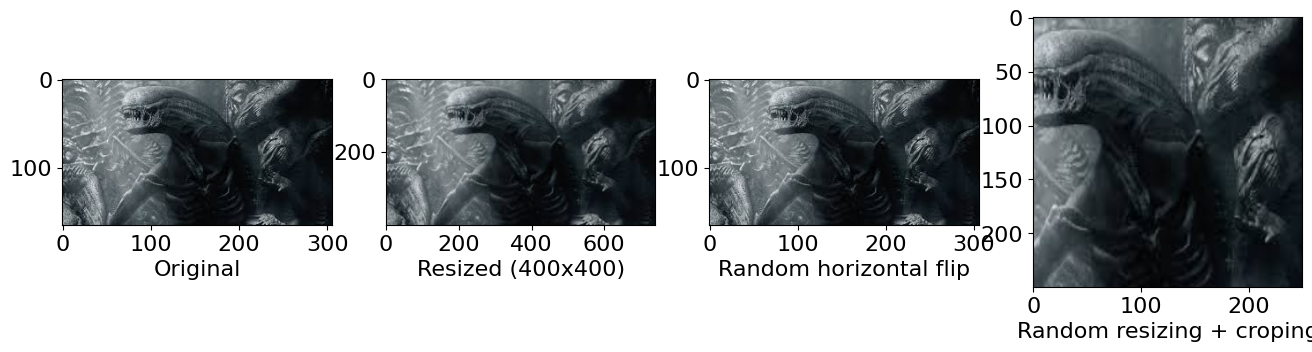

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import (
    Compose,
    RandomResizedCrop,
    RandomHorizontalFlip,
    ToTensor,
    Resize,
    CenterCrop,
)

# Look at one image from the dataset
preview_data = ImageFolder(os.path.join(os.getcwd(), "data", "alien-vs-predator", "train"))
img, label = preview_data[2]

# Let's inspect the effect of the various transformers
fig = plt.figure(figsize=(16, 9))

def show_image(img, label):
    # permute turns (rgb, height, width) into (height, width, rgb)
    plt.imshow(tensor_transformer(img).permute(1, 2, 0))
    plt.xlabel(label)

tensor_transformer = ToTensor()
plt.subplot(1, 4, 1)
show_image(img, "Original")

resize_transformer = Resize(400)
plt.subplot(1, 4, 2)
show_image(resize_transformer(img), "Resized (400x400)")

horizontal_flip_transformer = RandomHorizontalFlip()
plt.subplot(1, 4, 3)
show_image(horizontal_flip_transformer(img), "Random horizontal flip")

random_resize_crop_transformer = RandomResizedCrop(250, scale=(0.5, 1))
plt.subplot(1, 4, 4)
show_image(random_resize_crop_transformer(img), "Random resizing + croping")

Note that the transformations above are random, so if you run the cell multiple times, you will see different results.

### Visualize some training samples

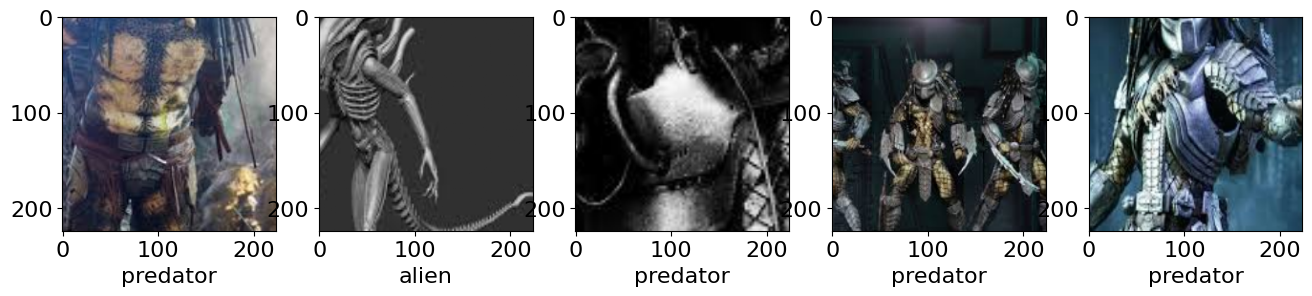

In [ ]:
# Take one batch from the train loader
data, labels = next(iter(train_loader))
data, labels = data[0:5], labels[0:5]

# Plot the images
fig = plt.figure(figsize=(16, 9))
for i in range(0, 5):
    fig.add_subplot(1, 5, i + 1)
    plt.imshow(data[i].permute(1, 2, 0))
    plt.xlabel(class_names[labels[i]])

---

# Loading a pre-trained model

### List of available pre-trained models

`torchvision` includes many pre-trained models. Let's get a list and have a look.

In [ ]:
for model in dir(torchvision.models):
    if model.startswith("_"): continue  # Skip private properties
    print(f"- {model}")

- AlexNet
- AlexNet_Weights
- ConvNeXt
- ConvNeXt_Base_Weights
- ConvNeXt_Large_Weights
- ConvNeXt_Small_Weights
- ConvNeXt_Tiny_Weights
- DenseNet
- DenseNet121_Weights
- DenseNet161_Weights
- DenseNet169_Weights
- DenseNet201_Weights
- EfficientNet
- EfficientNet_B0_Weights
- EfficientNet_B1_Weights
- EfficientNet_B2_Weights
- EfficientNet_B3_Weights
- EfficientNet_B4_Weights
- EfficientNet_B5_Weights
- EfficientNet_B6_Weights
- EfficientNet_B7_Weights
- EfficientNet_V2_L_Weights
- EfficientNet_V2_M_Weights
- EfficientNet_V2_S_Weights
- GoogLeNet
- GoogLeNetOutputs
- GoogLeNet_Weights
- Inception3
- InceptionOutputs
- Inception_V3_Weights
- MNASNet
- MNASNet0_5_Weights
- MNASNet0_75_Weights
- MNASNet1_0_Weights
- MNASNet1_3_Weights
- MaxVit
- MaxVit_T_Weights
- MobileNetV2
- MobileNetV3
- MobileNet_V2_Weights
- MobileNet_V3_Large_Weights
- MobileNet_V3_Small_Weights
- RegNet
- RegNet_X_16GF_Weights
- RegNet_X_1_6GF_Weights
- RegNet_X_32GF_Weights
- RegNet_X_3_2GF_Weights
- RegNet_X_4

### We will use the ResNet-18 architecture:
![ResNet-picture](https://www.researchgate.net/profile/Sajid-Iqbal-13/publication/336642248/figure/fig1/AS:839151377203201@1577080687133/Original-ResNet-18-Architecture.png)

It's very simple to create a module that has this model with its weights pre-trained for ImageNet.

In [ ]:
model_ft = torchvision.models.resnet18(pretrained=True)
model_ft

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 48.5MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### A closer look at the ResNet-18

The last fully connected layer has a 1000 output neurons. It has been trained on ImageNet task which has 1000 image classes.

In [ ]:
model_ft.fc

Linear(in_features=512, out_features=1000, bias=True)

We would like to perform binary classification (alien/predator). Therefore, we have to replace the last fully-connected layer to suit our needs (two output units).

In [ ]:
model_ft.fc = nn.Linear(in_features=512, out_features=2)

In [ ]:
model_ft.fc

Linear(in_features=512, out_features=2, bias=True)

---

# Training just the last layer

### Freeze all the layers except the last fully-connected one

**First way**

In [ ]:
for name, param in model_ft.named_parameters():
    if name not in ["fc.weight", "fc.bias"]:
        param.requires_grad = False

**Second way**

In [ ]:
model_ft.requires_grad_(False)
model_ft.fc.requires_grad_(True)

Linear(in_features=512, out_features=2, bias=True)

**Third way**

A third way could be to pass to the optimiser only the parameters of the last linear layer.  
However, this is not as good as the previous methods, do you see why ?  
Hint: All the gradients are still computed...

### Define the train and accuracy functions

So, now the architecture contains two output units, we can therefore use it to perform binary classification.

The *train* and _accuracy_ function are almost identical to the functions we used when traininig the CNN. This again nicely demonstrates the modularity of PyTorch and its simple interface.

In [ ]:
import colorama

def train(
    model,
    train_loader,
    test_loader,
    device,
    num_epochs=3,
    learning_rate=0.1,
    decay_learning_rate=False,
):
    # Some models behave differently in training and testing mode (Dropout, BatchNorm)
    # so it is good practice to specify which behavior you want.
    model.train()

    # We will use the Adam with Cross Entropy loss
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss()

    if decay_learning_rate:
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, 0.85)

    # We make multiple passes over the dataset
    for epoch in range(num_epochs):
        print("=" * 40, "Starting epoch %d" % (epoch + 1), "=" * 40)

        if decay_learning_rate:
            scheduler.step()

        total_epoch_loss = 0.0
        # Make one pass in batches
        for batch_number, (data, labels) in enumerate(train_loader):
            data, labels = data.to(device), labels.to(device)

            optimizer.zero_grad()

            output = model(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            total_epoch_loss += loss.item()

            if batch_number % 5 == 0:
                print("Batch %d/%d" % (batch_number, len(train_loader)))

        train_acc = accuracy(model, train_loader, device)
        test_acc = accuracy(model, test_loader, device)

        print(
            colorama.Fore.GREEN
            + "\nEpoch %d/%d, Loss=%.4f, Train-Acc=%d%%, Valid-Acc=%d%%"
            % (
                epoch + 1,
                num_epochs,
                total_epoch_loss / len(train_data),
                100 * train_acc,
                100 * test_acc,
            ),
            colorama.Fore.RESET,
        )


In [ ]:
def accuracy(model, data_loader, device):
    model.eval()

    num_correct = 0
    num_samples = 0
    with torch.no_grad():  # deactivates autograd, reduces memory usage and speeds up computations
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)

            predictions = torch.argmax(model(data), 1)  # find the class number with the largest output
            num_correct += (predictions == labels).sum().item()
            num_samples += len(predictions)

    return num_correct / num_samples

### Launch training (Tranfer Learning)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft.to(device)

train(model_ft, train_loader, test_loader, device, num_epochs=5)

======================================== Starting epoch 1 ========================================
Batch 0/22
Batch 5/22
Batch 10/22
Batch 15/22
Batch 20/22

Epoch 1/20, Loss=0.1979, Train-Acc=80%, Valid-Acc=82% 
======================================== Starting epoch 2 ========================================
Batch 0/22
Batch 5/22
Batch 10/22
Batch 15/22
Batch 20/22

Epoch 2/20, Loss=0.0462, Train-Acc=89%, Valid-Acc=93% 
======================================== Starting epoch 3 ========================================
Batch 0/22
Batch 5/22
Batch 10/22
Batch 15/22
Batch 20/22

Epoch 3/20, Loss=0.0281, Train-Acc=90%, Valid-Acc=90% 
======================================== Starting epoch 4 ========================================
Batch 0/22
Batch 5/22
Batch 10/22
Batch 15/22
Batch 20/22

Epoch 4/20, Loss=0.0338, Train-Acc=88%, Valid-Acc=87% 
======================================== Starting epoch 5 ========================================
Batch 0/22
Batch 5/22
Batch 10/22
Batch 15/22
Bat

### Inspecting the model's predictions

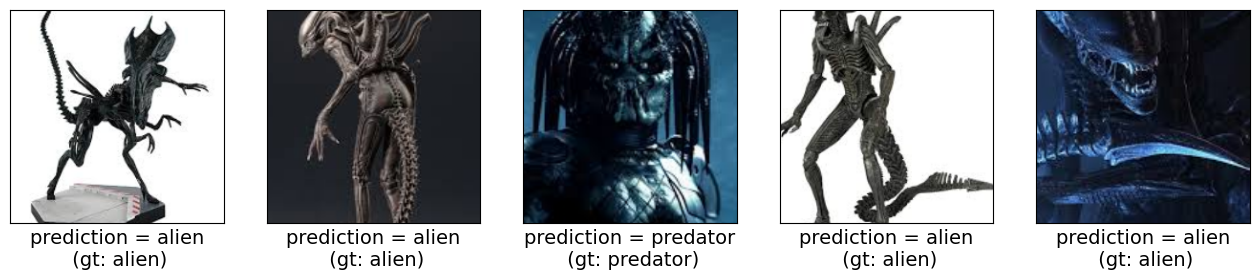

In [ ]:
data, labels = next(iter(DataLoader(test_data, batch_size=5, shuffle=True)))
data, labels = data.to(device), labels
predictions = torch.argmax(model_ft(data), 1).cpu()

predictions, data = predictions.cpu(), data.cpu()  # put it back on CPU for visualization

plt.figure(figsize=(16, 9))
for i in range(5):
    img = data.squeeze(1)[i]
    plt.subplot(1, 5, i + 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.xlabel(
        "prediction = %s\n (gt: %s)"
        % (test_data.classes[predictions[i].item()], test_data.classes[labels[i]]),
        fontsize=14,
    )
    plt.xticks([])
    plt.yticks([])

# Fine Tunning

### Again use the ResNet-18 architecture:
![ResNet-picture](https://www.researchgate.net/profile/Sajid-Iqbal-13/publication/336642248/figure/fig1/AS:839151377203201@1577080687133/Original-ResNet-18-Architecture.png)

Load the pytorch pretrained Resnet18 for ImageNet.

In [ ]:
model_fine_tuned = torchvision.models.resnet18(pretrained=True)
model_fine_tuned

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### A closer look at the ResNet-18

The last fully connected layer has a 1000 output neurons. It has been trained on ImageNet task which has 1000 image classes.

In [ ]:
model_fine_tuned.fc

Linear(in_features=512, out_features=1000, bias=True)

We would like to perform binary classification (alien/predator). Therefore, we have to replace the last fully-connected layer to suit our needs (two output units).

In [ ]:
model_fine_tuned.fc = nn.Linear(in_features=512, out_features=2)

In [ ]:
model_fine_tuned.fc

Linear(in_features=512, out_features=2, bias=True)

---

# Training just the last layer (Transfer Learning)

### Launch training (Fine Tuning)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_fine_tuned.to(device)

train(model_fine_tuned, train_loader, test_loader, device, num_epochs=5)

======================================== Starting epoch 1 ========================================
Batch 0/22
Batch 5/22
Batch 10/22
Batch 15/22
Batch 20/22

Epoch 1/20, Loss=0.1828, Train-Acc=90%, Valid-Acc=88% 
======================================== Starting epoch 2 ========================================
Batch 0/22
Batch 5/22
Batch 10/22
Batch 15/22
Batch 20/22

Epoch 2/20, Loss=0.0361, Train-Acc=90%, Valid-Acc=88% 
======================================== Starting epoch 3 ========================================
Batch 0/22
Batch 5/22
Batch 10/22
Batch 15/22
Batch 20/22

Epoch 3/20, Loss=0.0380, Train-Acc=87%, Valid-Acc=88% 
======================================== Starting epoch 4 ========================================
Batch 0/22
Batch 5/22
Batch 10/22
Batch 15/22
Batch 20/22

Epoch 4/20, Loss=0.0512, Train-Acc=87%, Valid-Acc=88% 
======================================== Starting epoch 5 ========================================
Batch 0/22
Batch 5/22
Batch 10/22
Batch 15/22
Bat

### Inspecting the model's predictions

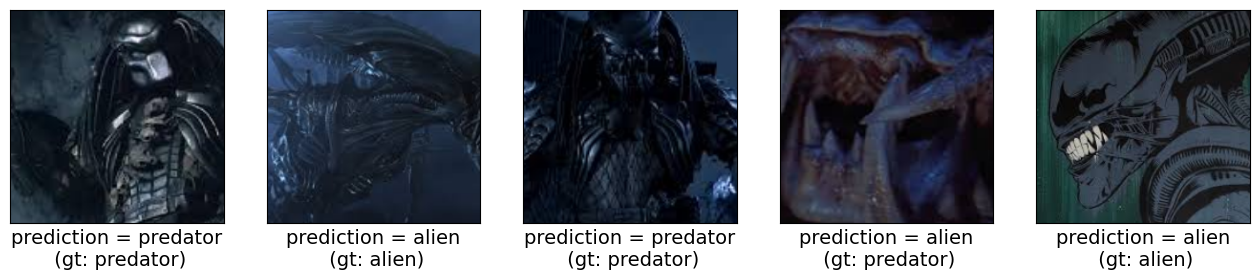

In [ ]:
data, labels = next(iter(DataLoader(test_data, batch_size=5, shuffle=True)))
data, labels = data.to(device), labels
predictions = torch.argmax(model_ft(data), 1).cpu()

predictions, data = predictions.cpu(), data.cpu()  # put it back on CPU for visualization

plt.figure(figsize=(16, 9))
for i in range(5):
    img = data.squeeze(1)[i]
    plt.subplot(1, 5, i + 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.xlabel(
        "prediction = %s\n (gt: %s)"
        % (test_data.classes[predictions[i].item()], test_data.classes[labels[i]]),
        fontsize=14,
    )
    plt.xticks([])
    plt.yticks([])

<!--NAVIGATION-->
# < [CNN](6-CNN.ipynb) | Transfer Learning |